In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_quantile_ci, classical_quantile_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

# Import the gene expression data set

In [2]:
dataset_folder = './data/'
data = load_dataset(dataset_folder, 'gene_expression')
Y_total = data['Y']
Yhat_total = data['Yhat']

# Problem setup

In [3]:
alpha = 0.05
n_total = Y_total.shape[0] # Total number of labeled examples
ns = np.linspace(100,2000,5).astype(int) # Test for different numbers of labeled examples
num_trials = 50

# True quantiles (computed on all data)
true_quantile_q25 = np.quantile(Y_total, 0.25)
true_quantile_q50 = np.quantile(Y_total, 0.5)
true_quantile_q75 = np.quantile(Y_total, 0.75)

q = 0.5 # Target problem is inference on the median

# Construct intervals

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[n:]
        
        ppi_ci = ppi_quantile_ci(_Y, _Yhat, _Yhat_unlabeled, q, alpha=alpha)
        
        # Classical interval
        classical_ci = classical_quantile_ci(_Y, q, alpha=alpha)
        
        # Append results
        results += [pd.DataFrame([{
            "method": "PPI",
            "n": n,
            "lower": ppi_ci[0],
            "upper": ppi_ci[1],
            "trial": j,
        }])]
        results += [pd.DataFrame([{
            "method": "Classical",
            "n": n,
            "lower": classical_ci[0],
            "upper": classical_ci[1],
            "trial": j,
        }])]
        
# Imputed CI
imputed_ci = classical_quantile_ci(Yhat_total, q, alpha=alpha)
results += [pd.DataFrame([{
    "method": "Imputation",
    "n": np.nan,
    "lower": imputed_ci[0],
    "upper": imputed_ci[1],
    "trial": 0,
}])]

df = pd.concat(results,axis=0,ignore_index=True)
df['width'] = df['upper'] - df['lower']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:04<00:00, 72.98s/it]


# Plot results

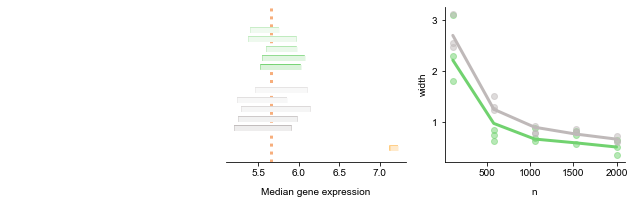

In [5]:
make_plots(df, './plots/gene_expression.pdf', intervals_xlabel="Median gene expression", true_theta=true_quantile_q50)

In [6]:
# Find n such that we reject H0: gene expression < 5 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [np.random.permutation(n_total) for i in range(num_experiments)]

def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_quantile_ci(_Y, _Yhat, _Yhat_unlabeled, q, alpha=alpha)
        if ppi_ci[0] > 5:
            nulls_rejected += 1
    return nulls_rejected/num_experiments - 0.8

def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_quantile_ci(_Y, q, alpha=alpha)
        
        if classical_ci[0] > 5:
            nulls_rejected += 1
    return nulls_rejected/num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=10))
n_classical = int(brentq(_to_invert_classical, 100, 2000, xtol=10))
print(f"The PPI test requires n={n_ppi} labeled data points to reject the null.")
print(f"The classical test requires n={n_classical} labeled data points to reject the null.")

The PPI test requires n=764 labeled data points to reject the null.
The classical test requires n=900 labeled data points to reject the null.
